# Clasificación por Regresión Logística

Cargamos los paquetes


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

Y ahora cargamos los datos


In [2]:
df = pd.read_csv("../data/match_data_no_gold.csv")

X = df.drop(columns=["blueTeamWin"])
y = df["blueTeamWin"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])

Ahora hacemos validación cruzada


In [5]:
param_grid = {
    "logreg__C": list(range(1, 10))
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"Mejor C: {grid_search.best_params_['logreg__C']}")
print(f"Mejor ROC en CV: {grid_search.best_score_:.4f}")

Mejor C: 2
Mejor ROC en CV: 0.8448


Ahora veamos el rendimiento en el conjunto de test


In [5]:
y_pred = best_model.predict(X_val)

print("Matriz de Confusión:")
print(confusion_matrix(y_val, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_val, y_pred))

Matriz de Confusión:
[[1819  616]
 [ 615 1794]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      2435
           1       0.74      0.74      0.74      2409

    accuracy                           0.75      4844
   macro avg       0.75      0.75      0.75      4844
weighted avg       0.75      0.75      0.75      4844




Importancia de las variables (Pesos):
                    Variable  Coeficiente
9                     xpDiff     0.904144
2             totalKillsDiff     0.860107
3            dragonKillsDiff     0.524921
5        towersDestroyedDiff     0.241611
10   totalDamageToChampsDiff     0.181788
7            laneMinionsDiff     0.181049
6   towerPlatesDestroyedDiff    -0.156721
4            heraldKillsDiff     0.067909
8          jungleMinionsDiff     0.058483
12      totalTowersDestroyed     0.049431
14        blueTeamFirstBlood     0.041898
0     controlWardsPlacedDiff    -0.039053
1            wardsPlacedDiff    -0.014233
13          totalWardsPlaced    -0.007689
11                totalKills    -0.004332


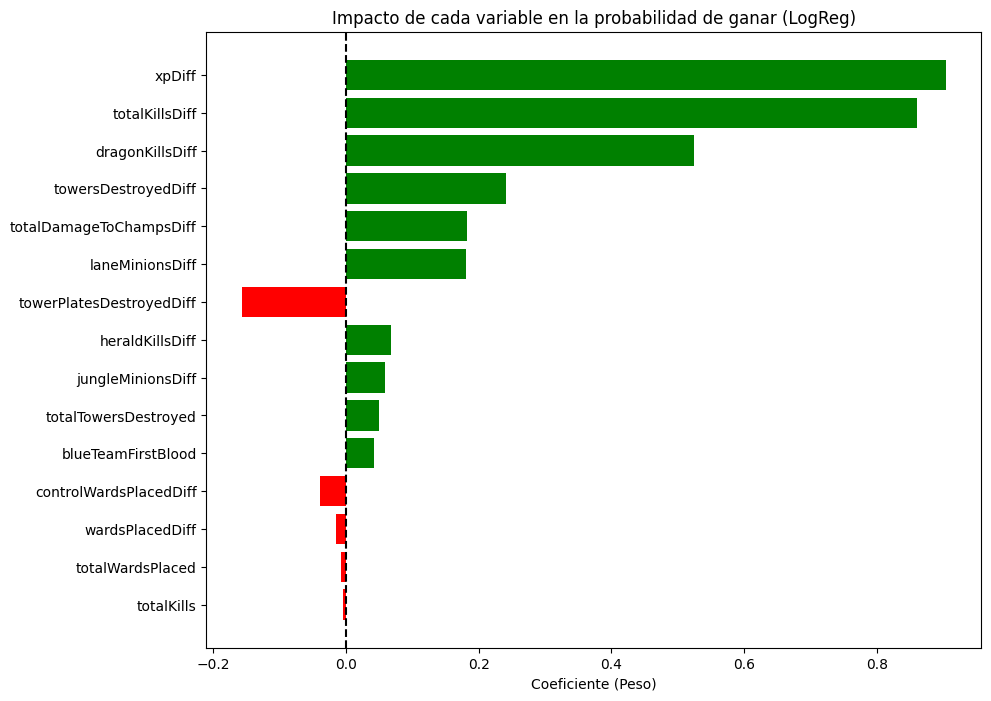

In [6]:
# Extraer el modelo y los nombres de columnas
model_logreg = best_model.named_steps['logreg']
coeficientes = model_logreg.coef_[0]
intercept = model_logreg.intercept_[0]
nombres_cols = X.columns

# Crear DataFrame de coeficientes
df_coefs = pd.DataFrame({
    'Variable': nombres_cols,
    'Coeficiente': coeficientes,
    'Abs_Coef': abs(coeficientes)  # Para ordenar por magnitud
}).sort_values(by='Abs_Coef', ascending=False)

print("\nImportancia de las variables (Pesos):")
print(df_coefs[['Variable', 'Coeficiente']])

# Gráfico de Coeficientes
plt.figure(figsize=(10, 8))
# Colorear: Verde si es positivo (ayuda a Blue), Rojo si es negativo
colors = ['green' if c > 0 else 'red' for c in df_coefs['Coeficiente']]
plt.barh(df_coefs['Variable'], df_coefs['Coeficiente'], color=colors)
plt.title("Impacto de cada variable en la probabilidad de ganar (LogReg)")
plt.xlabel("Coeficiente (Peso)")
plt.axvline(x=0, color='black', linestyle='--')  # Línea central
plt.gca().invert_yaxis()  # Invertir eje Y para ver las más importantes arriba
plt.show()

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

try:
    import google.colab
    pio.renderers.default = 'colab'
    print("Entorno detectado: Google Colab. Renderizador configurado como 'colab'.")
except ImportError:
    pio.renderers.default = 'notebook'
    print("Entorno detectado: Local (jupyter). Renderizador configurado como 'notebook'.")
from scipy.special import expit
X_scaled = RobustScaler().set_output(transform="pandas").fit_transform(X_train)

x = X_scaled["totalKillsDiff"]
y = X_scaled["xpDiff"]

b0 = np.sort(coeficientes)[-1]
b1 = np.sort(coeficientes)[-2]
x_range = np.linspace(x.min(), x.max(), 100)
y_range = np.linspace(y.min(), y.max(), 100)
xx, yy = np.meshgrid(x_range, y_range)

zz = expit(intercept + b0*xx + b1*yy)
plan = zz/zz * 0.5


linea_x = np.linspace(x.min(), x.max(), 100)
linea_y = -(intercept + b0 * linea_x) / b1
linea_z = np.full_like(linea_x, 0.5)

puntos_x = linea_x[::10]
puntos_y = linea_y[::10]
line_z = np.linspace(0, 0.5, 100)
fig = go.Figure()


# Puntos de los datos
fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=y_train,
    opacity=0.8,
    mode='markers',
    marker=dict(size=5, color=y_train, colorscale='Viridis'),
    name='Data'
))


# Superficie función logística
fig.add_trace(
    go.Surface(
        x=xx,
        y=yy,
        z=zz,
        name='Logreg',
        opacity=0.7,
        showscale=False,
        colorscale='viridis'
    )
)

# Plano horizontal
fig.add_trace(
    go.Surface(
        x=xx,
        y=yy,
        z=plan,
        name='Hiperplano z=0.5',
        opacity=0.7,
        showscale=False,
        colorscale='viridis',
    ),

)
# Líneas verticales proyecciones
for i in range(len(puntos_x)):
    line_x = np.ones_like(line_z)*puntos_x[i]
    line_y = np.ones_like(line_z)*puntos_y[i]
    fig.add_trace(go.Scatter3d(
        x=line_x,
        y=line_y,
        z=line_z,
        mode='lines',
        line=dict(color='black', width=5, dash='dash'),  # Línea punteada negra
        showlegend=False
    ))

# Interseccion
fig.add_trace(go.Scatter3d(
    x=linea_x,
    y=linea_y,
    z=linea_z,
    mode='lines',
    line=dict(color='black', width=5, dash='dash'),  # Línea punteada negra
    name='Interseccion'
))

# Proyeccion de la interseccion
fig.add_trace(go.Scatter3d(
    x=linea_x,
    y=linea_y,
    z=np.zeros_like(linea_x),
    mode='lines',
    line=dict(color='black', width=5, dash='dash'),
    showlegend=False
))

fig.add_trace(go.Scatter3d(
    x=puntos_x,
    y=puntos_y,
    z=np.zeros_like(puntos_x),
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Frontera de predicción'
))

fig.update_layout(
    scene=dict(
        xaxis_title="totalKillsDiff",
        yaxis_title="xpDiff",
        zaxis_title="target",
    ),
    title='Scatter Plot',
    margin=dict(l=0, r=0, b=0, t=40)
)
fig.show()

ModuleNotFoundError: No module named 'plotly'

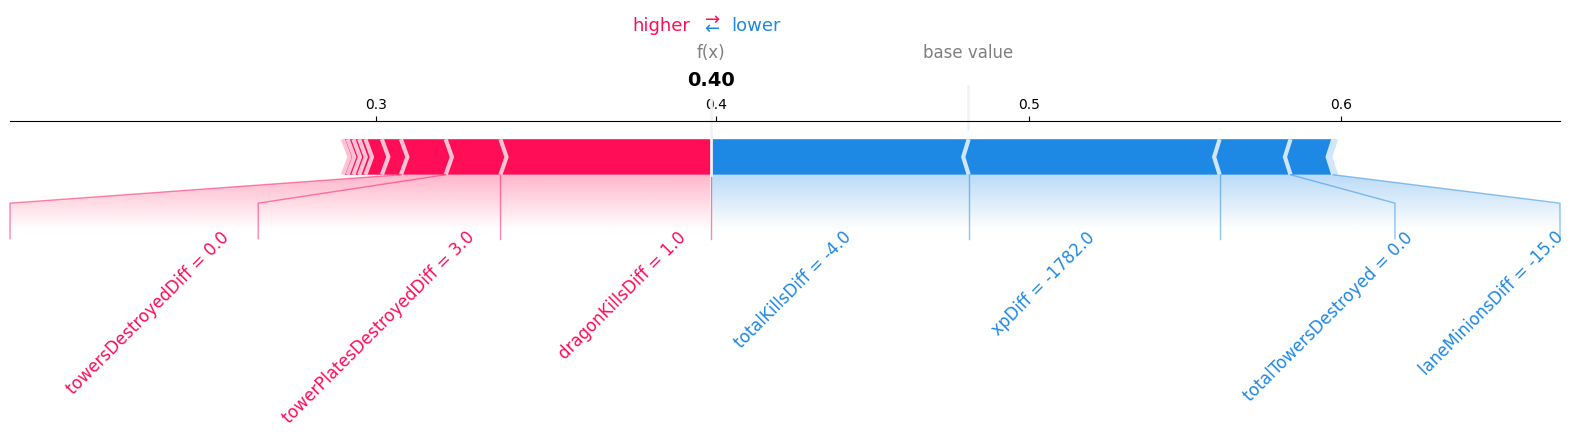

In [48]:
import shap

# 1. Extraer las piezas del Pipeline
scaler: RobustScaler = best_model.named_steps['scaler']
model_logreg = best_model.named_steps['logreg']

# 2. Preparar los datos CORRECTOS (Escalados) para el Explainer
# Tomamos la muestra cruda y la escalamos
sample_data_raw = shap.sample(X_val, 100, random_state=0)
sample_data_scaled = scaler.transform(sample_data_raw)

# Tomamos la instancia cruda y la escalamos
instance_raw = X_val.iloc[[0]]  # DataFrame (crudo)
instance_scaled = scaler.transform(instance_raw)  # Numpy Array (escalado)

# 3. Crear el Explainer con datos ESCALADOS
# Ahora el modelo recibe lo que espera (números pequeños)
explainer = shap.LinearExplainer(model_logreg, sample_data_scaled)

# 4. Calcular SHAP values sobre la instancia ESCALADA
shap_values = explainer.shap_values(instance_scaled)

shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    instance_raw.iloc[0],
    matplotlib=True,
    text_rotation=45,
    link="logit"
)

In [49]:
shap_values_summary = explainer.shap_values(sample_data_scaled)

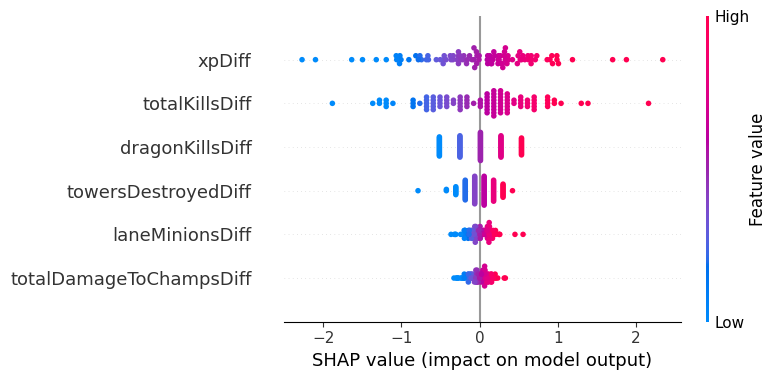

In [50]:
plt.figure(dpi=100)

shap.summary_plot(
    shap_values_summary,
    sample_data_raw,
    max_display=6,
    plot_type="dot",
    show=False
)

Una vez elegimos este como el mejor modelo, vemos el reporte de clasificación con los datos de test:


In [7]:
y_pred = best_model.predict(X_test)

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

Matriz de Confusión:
[[1877  578]
 [ 601 1788]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      2455
           1       0.76      0.75      0.75      2389

    accuracy                           0.76      4844
   macro avg       0.76      0.76      0.76      4844
weighted avg       0.76      0.76      0.76      4844

